<a href="https://colab.research.google.com/github/iam-Dylan/automated-essay-scoring/blob/meo/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk
# nltk.download('punkt')
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
warnings.filterwarnings('ignore')



In [135]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [136]:
test  = pd.read_csv("drive/MyDrive/Colab Notebooks/data/test.csv")
train = pd.read_csv('drive/MyDrive/Colab Notebooks/data/train.csv')
test

,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [137]:
train.shape

(17307, 3)

In [138]:
data = train.copy()


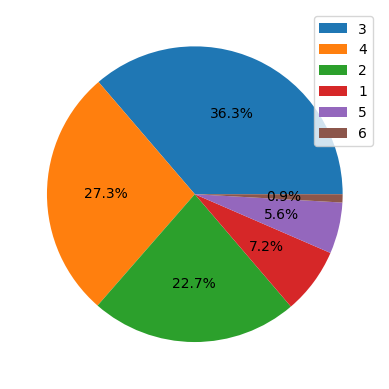

In [139]:
plt.pie(data['score'].value_counts(), autopct='%1.1f%%')
plt.legend(labels = data['score'].unique(), loc = 'upper right')
plt.show()

Ti le diem trong lop phan lon 2-3-4 diem
-> du lieu bi mat can bang


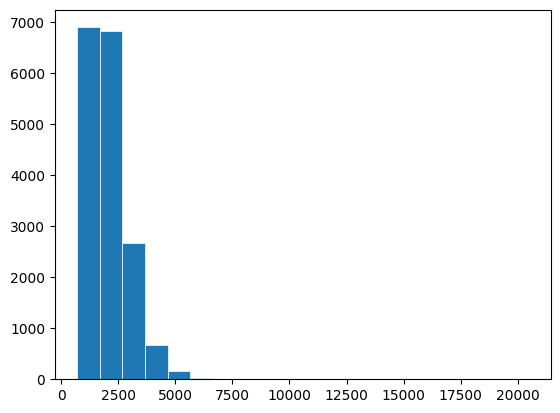

In [140]:
# do dai essay
plt.hist(data['full_text'].str.len(), bins=20,edgecolor='w', linewidth=0.5)
# plt.xscale('log')
plt.show()

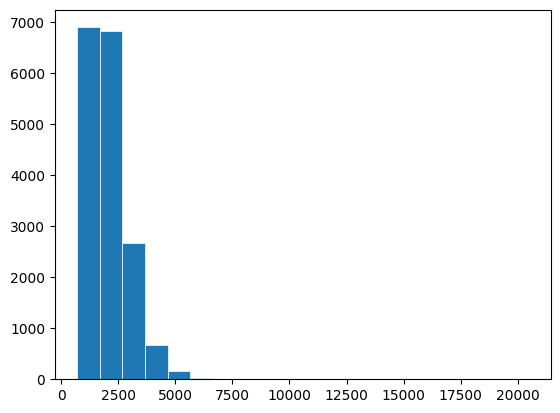

In [141]:
# do dai essay
data['len_text'] = data['full_text'].str.len() ;
plt.hist(data['len_text'], bins=20, edgecolor='w', linewidth=0.5)
# sns.distplot(data['len_text'], hist=False)
plt.show()

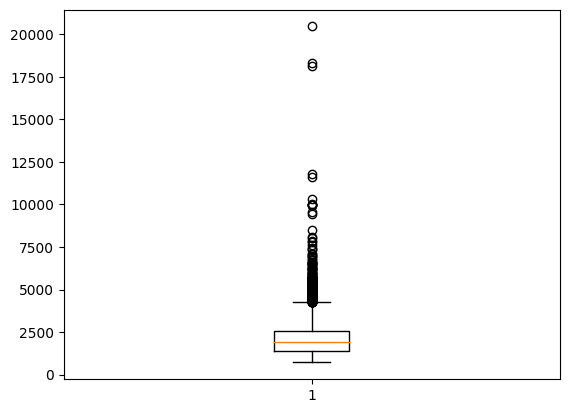

In [142]:
plt.boxplot(data['len_text'])
plt.show()


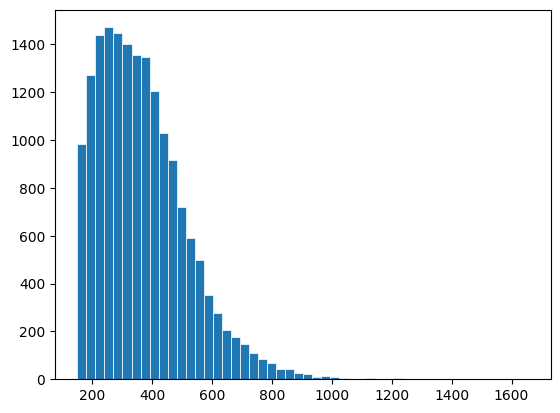

In [143]:
# so tu moi essay
def word_count(df):
    df = df.split()
    return len(df)

data['word_count'] = data['full_text'].agg(word_count)
plt.hist(data['word_count'], bins=50,edgecolor='w', linewidth=0.5)
plt.show()


In [144]:
# trung binh do dai tu trong moi essay
data['mean_word_length'] = data['full_text'].map(lambda text: np.mean([len(word) for word in text.split()]))
data.head(10)

,essay_id,full_text,score,len_text,word_count,mean_word_length
0,000d118,Many people have car where they live. The thin...,3,2677,498,4.369478
1,000fe60,I am a scientist at NASA that is discussing th...,3,1669,332,4.018072
2,001ab80,People always wish they had the same technolog...,4,3077,550,4.574545
3,001bdc0,"We all heard about Venus, the planet without a...",4,2701,451,4.982262
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,2208,373,4.873995
5,0030e86,If I were to choose between keeping the electo...,4,2374,400,4.890000
6,0033037,The posibilty of a face reconizing computer wo...,2,1031,179,4.754190
7,0033bf4,What is the Seagoing Cowboys progam?\n\nIt was...,3,1992,353,4.569405
8,0036253,The challenge of exploring Venus\n\nThis stori...,2,1870,310,5.003226
9,0040e27,There are many reasons why you should join sea...,3,1521,280,4.417857


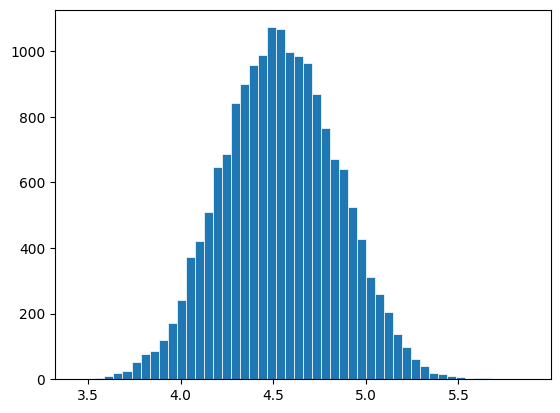

In [145]:
plt.hist(data['mean_word_length'], bins=50,edgecolor='w', linewidth=0.5);
plt.show()

In [146]:
# mean of (length sentence
data['mean_sent_length'] = data['full_text'].map(lambda rev: np.mean([len(sent) for sent in sent_tokenize(rev)]))
data.head(10)

,essay_id,full_text,score,len_text,word_count,mean_word_length,mean_sent_length
0,000d118,Many people have car where they live. The thin...,3,2677,498,4.369478,204.692308
1,000fe60,I am a scientist at NASA that is discussing th...,3,1669,332,4.018072,78.333333
2,001ab80,People always wish they had the same technolog...,4,3077,550,4.574545,126.750000
3,001bdc0,"We all heard about Venus, the planet without a...",4,2701,451,4.982262,133.950000
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,2208,373,4.873995,145.266667
5,0030e86,If I were to choose between keeping the electo...,4,2374,400,4.890000,97.208333
6,0033037,The posibilty of a face reconizing computer wo...,2,1031,179,4.754190,146.142857
7,0033bf4,What is the Seagoing Cowboys progam?\n\nIt was...,3,1992,353,4.569405,74.653846
8,0036253,The challenge of exploring Venus\n\nThis stori...,2,1870,310,5.003226,102.444444
9,0040e27,There are many reasons why you should join sea...,3,1521,280,4.417857,64.956522


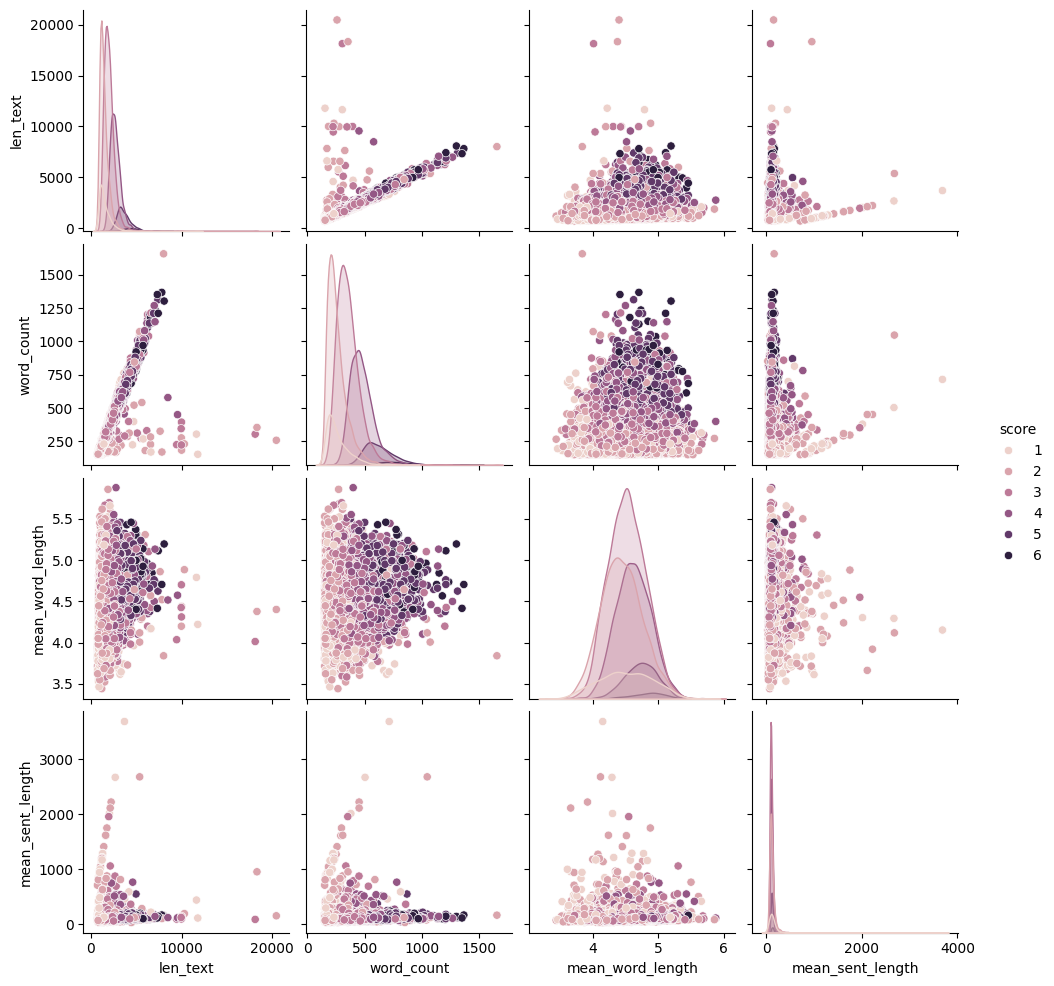

In [147]:
col = ['len_text', 'word_count', 'mean_word_length', 'mean_sent_length', 'score']
sns.pairplot(data[col], hue ='score') # hue - label
plt.show()


In [148]:
data[col].corr()

,len_text,word_count,mean_word_length,mean_sent_length,score
len_text,1.000000,0.919812,0.261789,0.037794,0.648500
word_count,0.919812,1.000000,0.161977,0.022829,0.690035
mean_word_length,0.261789,0.161977,1.000000,0.030563,0.247494
mean_sent_length,0.037794,0.022829,0.030563,1.000000,-0.068506
score,0.648500,0.690035,0.247494,-0.068506,1.000000


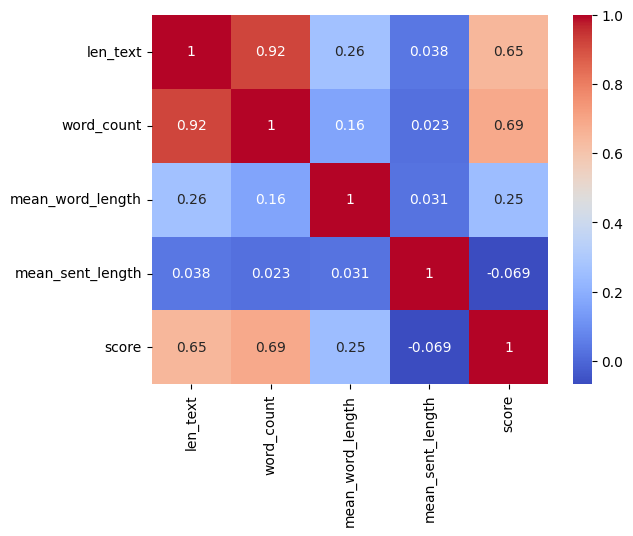

In [149]:
sns.heatmap(data[col].corr(), annot = True, cmap = 'coolwarm')
plt.show()

score - len_text

score - word count

EDA về từ(?) trên essay (tan suat, ngram, stop word)